### Configuration initiale et importation des paquets

Dans cette section, nous importons plusieurs paquets essentiels pour notre analyse. Voici une explication de chaque paquet :

- `Plots` : Ce paquet est utilisé pour créer une grande variété de graphiques et de visualisations. Nous importons également `plot!` et `vline!` de `Plots` pour des fonctionnalités de tracé supplémentaires.
- `LinearAlgebra` : Ce paquet fournit une collection de fonctionnalités d'algèbre linéaire, telles que les opérations matricielles et les décompositions.
- `Optim` : Ce paquet est utilisé pour l'optimisation mathématique, offrant des algorithmes pour trouver le minimum ou le maximum de fonctions.
- `Statistics` : Ce paquet fournit des fonctions statistiques de base, telles que les calculs de moyenne, de variance et d'écart-type.
- `Distributions` : Ce paquet nous permet de travailler avec des distributions de probabilité, offrant des fonctions pour définir, échantillonner et manipuler différents types de distributions.
- `Random` : Ce paquet fournit des fonctionnalités pour la génération de nombres aléatoires, permettant la reproductibilité et le contrôle du hasard dans les simulations.

In [50]:
using Plots
import Plots: plot!, vline!
using LinearAlgebra
using Optim
using Statistics
using Distributions
using Random

### Définition de la structure `WienerProcess`

Dans cette section, nous définissons une structure mutable appelée `WienerProcess` pour représenter un processus de Wiener, également connu sous le nom de mouvement brownien. Voici une explication des composants de cette structure :

- `mu::T` : La dérive (moyenne) du processus, de type `T` (qui doit être un sous-type de `Number`).
- `sigma2::T` : La variance du processus, de type `T`.
- `timestep::T` : Le pas de temps entre chaque étape du processus, de type `T`.
- `values::Vector{T}` : Un vecteur pour stocker les valeurs du processus simulé, de type `T`.
- `steps::Int` : Le nombre d'étapes de temps dans le processus.
- `times::Vector{T}` : Un vecteur pour stocker les temps correspondants à chaque valeur du processus, de type `T`.

#### Constructeur

Le constructeur `WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number` initialise le processus sans valeurs simulées. Voici comment il fonctionne :

- `mu`, `sigma2`, `timestep`, et `steps` sont passés en tant que paramètres.
- `values` est initialisé comme un vecteur non défini de type `T` et de longueur `steps + 1`.
- `times` est initialisé en utilisant la fonction `collect` pour créer une séquence de temps allant de `0` à `steps * timestep`, avec un pas de `timestep`.

En utilisant `new{T}`, nous créons une instance de `WienerProcess` avec les valeurs spécifiées.


In [51]:
mutable struct WienerProcess{T<:Number}
    mu::T
    sigma2::T
    timestep::T
    values::Vector{T}
    steps::Int
    times::Vector{T}

    # Constructeur pour initialiser le processus sans valeurs simulées
    function WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number
        new{T}(mu, sigma2, timestep, Vector{T}(undef, steps + 1), steps, collect(0:timestep:steps * timestep))
    end
end

### Fonction de simulation du processus de Wiener

Dans cette section, nous définissons une fonction pour simuler le processus de Wiener, qui met à jour les valeurs du processus à chaque étape de temps. Voici une explication détaillée de la fonction `simulate!` :

#### Fonction `simulate!`

```julia
function simulate!(wp::WienerProcess)


In [52]:
# Fonction pour simuler le processus de Wiener
function simulate!(wp::WienerProcess)
    sqrt_sigma2 = sqrt(wp.sigma2)
    wp.values = [0.0]
    normal_dist = Normal(0, 1)  # Définir une distribution normale standard
    for t in 1:wp.steps
        dt = wp.timestep
        dW = sqrt_sigma2 * sqrt(dt) * rand(normal_dist)
        new_value = wp.values[end] + wp.mu * dt + dW
        push!(wp.values, new_value)
    end
end

simulate! (generic function with 2 methods)

### Méthode pour tracer le processus de Wiener

Dans cette section, nous définissons une fonction pour tracer le processus de Wiener et la droite de dérive \( \mu t \). `plot!` :

In [53]:
# Méthode pour tracer le processus de Wiener
function plot!(process::WienerProcess)
    # Tracer le processus de Wiener
    plot!(process.times, process.values, xlabel="Time", ylabel="Wiener Process", label="Wiener Process", 
    linestyle=:dash, markercolor=:blue)
    
    # Tracer la droite mu*t
    plot!(process.times, process.mu .* process.times, label="mu*t", linestyle=:dash)
end

plot! (generic function with 6 methods)

#### Exemple de simulation d'un processus de Wiener

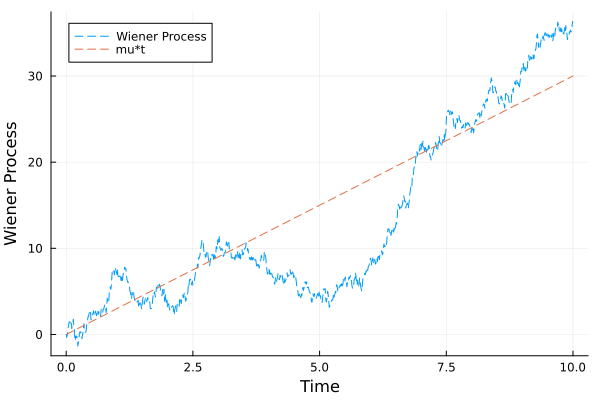

In [54]:
# Définir les paramètres du processus de Wiener
mu = 3.0
sigma2 = 16.0
timestep = 0.01
steps = 1000

# Créer une instance de WienerProcess
process = WienerProcess{Float64}(mu, sigma2, timestep, steps)

# Simuler le processus de Wiener
simulate!(process)

plot()
# Tracer le processus de Wiener simulé
plot!(process)

### Définition de la structure `WienerARD1`

Dans cette section, nous définissons une structure mutable appelée `WienerARD1` qui représente un processus de Wiener avec des interventions de maintenance à des temps spécifiques. Voici une explication des composants de cette structure :

#### Composants de `WienerARD1`

- `underlying_process::WienerProcess{Float64}` : Un processus de Wiener sous-jacent de type `Float64`.
- `rho::Float64` : Un paramètre de corrélation ou d'autocorrélation.
- `maintenance_times::Vector{Float64}` : Un vecteur contenant les temps de maintenance.
- `k::Int` : Le nombre de temps de maintenance.
- `values::Vector{Vector{Float64}}` : Un vecteur de vecteurs pour stocker les valeurs du processus après chaque intervalle de maintenance.
- `new_times::Vector{Vector{Float64}}` : Un vecteur de vecteurs pour stocker les nouveaux intervalles de temps jusqu'à chaque temps de maintenance.

#### Constructeur

Le constructeur `WienerARD1` initialise les paramètres du processus, simule le processus de Wiener sous-jacent, et divise les temps en intervalles définis par les temps de maintenance. 

In [55]:
mutable struct WienerARD1
    underlying_process::WienerProcess{Float64}
    rho::Float64
    maintenance_times::Vector{Float64}
    k::Int
    values::Vector{Vector{Float64}}
    new_times::Vector{Vector{Float64}}

    function WienerARD1(mu::Float64, sigma2::Float64, timestep::Float64, steps::Int, rho::Float64, maintenance_times::Vector{Float64})
        underlying_process = WienerProcess{Float64}(mu, sigma2, timestep, steps)
        simulate!(underlying_process)
        
        k = length(maintenance_times)
        
        # Initialize new_times array
        new_times = Vector{Vector{Float64}}()
        start_time = 0.0
        
        # Populate new_times with intervals up to each maintenance time
        for i in 1:length(maintenance_times)
            end_time = maintenance_times[i]
            push!(new_times,collect(start_time:timestep:end_time))
            start_time = end_time
        end
        
        # Last segment from last maintenance time to the end
        push!(new_times, collect(start_time:timestep:(steps * timestep)))
        
        new(underlying_process, rho, maintenance_times, k, Vector{Vector{Float64}}(), new_times)
    end
end

#### Fonction `simulate!` pour `WienerARD1`

Cette section définit une fonction `simulate!` pour mettre à jour les valeurs du processus `WienerARD1` selon le modèle ARD1 et selon la même structure que `new_times`. Voici une explication détaillée de la fonction :

#### Fonction `simulate!`

```julia
function simulate!(process::WienerARD1)


In [56]:
function simulate!(process::WienerARD1)
    
    # Créer un vecteur Y initialisé avec les valeurs de X
    Y = copy(process.underlying_process.values)
    
    # Modifier les valeurs de Y selon les règles spécifiées
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i+1]
        
        # Indices des temps entre deux instants de maintenance
        indices = findall(t -> t > maintenance_time && t <= next_maintenance_time, process.underlying_process.times)
        
        # Mettre à jour les valeurs de Y
        Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]  
    end
    
    indices = findall(t -> t > process.maintenance_times[length(process.maintenance_times)], process.underlying_process.times)
    Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]

    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)

    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, Y[1:last_before_maintenance])
    end

    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, (1 - process.rho) * process.underlying_process.values[between_maintenances[1]-1])
            append!(new_values, Y[between_maintenances])
        end
    end
    
    m = findfirst(t -> t == process.maintenance_times[end], process.underlying_process.times)
    append!(new_values, (1 - process.rho) * process.underlying_process.values[m])
    append!(new_values, Y[m+1:end])

    t1 = 1
    t2 = 0
   for i in 1:process.k+1
        t2 = length(process.new_times[i]) + t2
        push!(process.values, new_values[t1:t2])
        t1 = t2 + 1
   end
end

simulate! (generic function with 2 methods)

Exemple de simulation d'un processus de Wiener ARD1

In [112]:
mu = 3.0
sigma2 = 5.0
timestep = .01
steps = 1000
rho = 0.8
maintenance_times = [ 3. * i for i in 1:2]

# Créer une instance de WienerProcess
processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(processARD1)


### Méthode pour tracer le processus de Wiener ARD1 

Dans cette section, nous définissons une fonction pour tracer le processus de Wiener ARD1, son processus de Wiener sous-jacent et la droite de dérive \( \mu t \).

In [58]:
# Méthode pour tracer le processus de Wiener avec les temps de maintenance
function plot!(process::WienerARD1)
    # Tracer le processus de Wiener
    # plot(process.underlying_process.times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    plot(xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process")
    for i in 1:process.k+1
        plot!(process.new_times[i], process.values[i], linestyle=:dash, markercolor=:red, color=:blue, legend=:false)
    end
    # Tracer la droite mu*t
    plot!(process.underlying_process.times, process.underlying_process.mu .* process.underlying_process.times, label="mu*t", linestyle=:dash)

    vline!(process.maintenance_times, label="Maintenance Time", color=:red)
end


plot! (generic function with 6 methods)

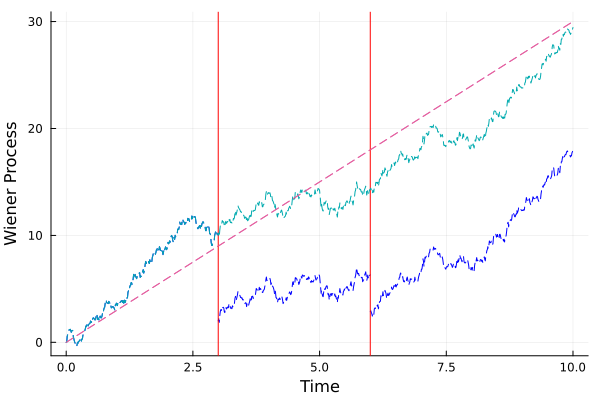

In [113]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
plot!(processARD1.underlying_process)

In [60]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 10
rho = 0.8
maintenance_times = [ 3. * i for i in 1:2]

# Créer une instance de WienerProcess
wp = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(wp)


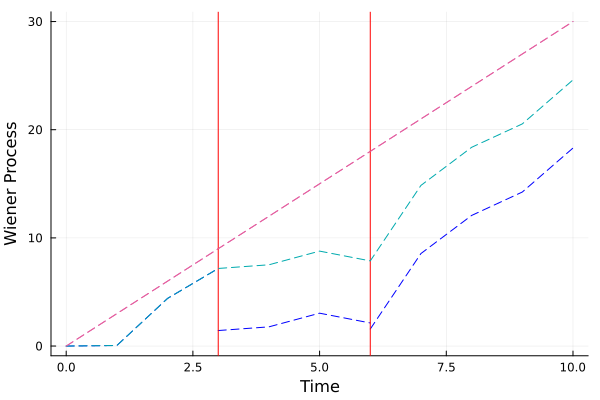

In [61]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(wp)
plot!(wp.underlying_process)

#### Fonction `observations_sampling` pour `WienerARD1`

Cette section définit une fonction `observations_sampling` qui échantillonne aléatoirement des observations à partir des valeurs du processus `WienerARD1`.

In [62]:
function observations_sampling(ps::WienerARD1, nb)
    observations = Vector{Vector{Float64}}()
    times = Vector{Vector{Float64}}()
    indices = collect(1:nb:length(ps.values[1])-nb)
    push!(observations, ps.values[1][indices])
    push!(times, ps.new_times[1][indices])
    for i in 2:ps.k + 1
        # Generate a deterministic set of indices, e.g., every third element
        indices = collect(nb+1:nb:length(ps.values[i])-nb)
        push!(observations, ps.values[i][indices])
        push!(times, ps.new_times[i][indices])
    end
    return observations, times
end


observations_sampling (generic function with 1 method)

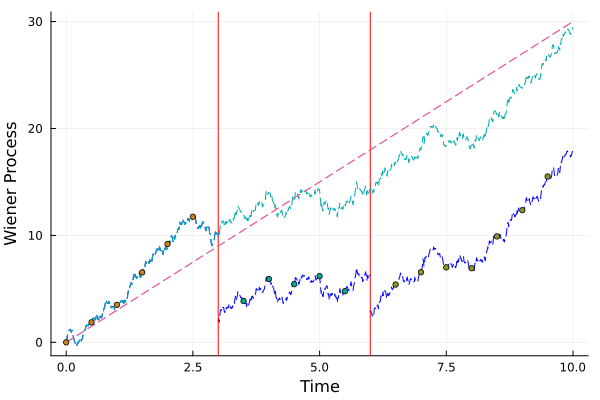

In [160]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
plot!(processARD1.underlying_process)
observations, times = observations_sampling(processARD1, 50)
for i in 1:processARD1.k+1
    scatter!(times[i], observations[i], markersize = 3)
end
plot!() 
# savefig("figure.png") 

### Implémentation des fonctions des estimateurs des paramètres `\mu`, `\sigma2` et `\rho`

In [161]:
observations

3-element Vector{Vector{Float64}}:
 [0.0, 1.8736360767690328, 3.5071343722832182, 6.539820353486789, 9.201138284752794, 11.746758630017732]
 [3.865982991641788, 5.919015822633227, 5.435281289579212, 6.186723665019528, 4.781453788437629]
 [5.405691676776671, 6.55468058325034, 7.011398532391047, 6.9297124191593, 9.906520078587691, 12.35594979324844, 15.507447265570823]

In [162]:
times

3-element Vector{Vector{Float64}}:
 [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
 [3.5, 4.0, 4.5, 5.0, 5.5]
 [6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]

In [163]:
delta2(times)

3-element Vector{Vector{Float64}}:
 [0.5, 0.5, 0.5, 0.5, 0.5]
 [0.5, 0.5, 0.5, 0.5]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [164]:
s(2, 0.5, 2, delta2(times))

0.75

In [165]:
Sigma(0.5, 2, delta2(times))

2×2 Matrix{Float64}:
  0.625  -0.25
 -0.25    0.75

In [166]:
delta2(observations)

3-element Vector{Vector{Float64}}:
 [1.8736360767690328, 1.6334982955141855, 3.0326859812035707, 2.661317931266005, 2.545620345264938]
 [2.053032830991439, -0.48373453305401526, 0.7514423754403161, -1.4052698765818992]
 [1.1489889064736687, 0.45671794914070674, -0.08168611323174702, 2.976807659428392, 2.4494297146607487, 3.151497472322383]

In [167]:
v(3, 0.5, 2, observations)

5.050877794397076

In [168]:
println(z(2, observations))

[-7.880775638375944, 0.6242378883390423]


In [169]:
Sigma_inv = inv(Sigma(0.5, 2, delta2(times)))

2×2 Matrix{Float64}:
 1.84615   0.615385
 0.615385  1.53846

In [170]:
Z = z(2, observations)

2-element Vector{Float64}:
 -7.880775638375944
  0.6242378883390423

In [171]:
Sigma_inv * Z

2-element Vector{Float64}:
 -14.164977862639256
  -3.8893421030943625

In [172]:
U = [u(j, 0.5, 2, delta2(times)) for j in 1:length(V)] #/

2-element Vector{Float64}:
 0.75
 0.5

In [173]:
a = dot(U, Sigma_inv * Z)

-12.568404448526625

In [174]:
V = [v(j, 0.5, 2, observations) for j in 1:size(Sigma_inv)[1]] #/


2-element Vector{Float64}:
 5.873379315008866
 0.45773539839792043

In [105]:
b = dot(U, Sigma_inv * V)

12.260552738485188

In [79]:
c = sum(map(sum, delta2(observations)))

22.71594406605066

In [80]:
c = sum(sum(dy) for dy in delta2(observations))

22.71594406605066

In [106]:
d = dot(U, Sigma_inv * U)

e = sum(map(sum, delta2(times)))

(a + b + c) / (d + e)

2.188117714709104

In [107]:
mu = mu_chapeau(0.75, 2, observations, delta2(times))

3.061147321184575

In [108]:
Z - mu .* U + V

2-element Vector{Float64}:
 -1.5616656091014312
 -4.312398602058657

In [109]:
sigma2_chapeau(0.75, 2, observations, delta2(times))

2.8361352029747335

In [110]:
b = dot(Z - mu .* U + V, Sigma_inv * (Z - mu .* U + V))

41.40147806811586

In [86]:
N = sum(length(observations[i]) for i in 1:2 + 1)

18

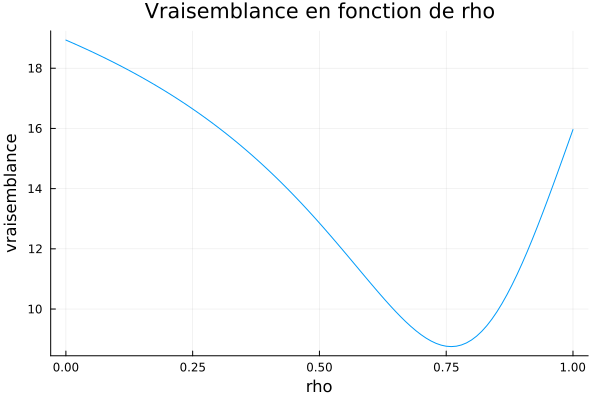

In [114]:
# Créer un vecteur de valeurs de rho entre 0 et 1
rhos = collect(0.0:0.01:1.)

# Calculer les valeurs de la fonction de vraisemblance pour chaque rho
vraisemblances = [objectif(rho, 2, observations, delta2(times), N) for rho in rhos]

# Tracer la fonction de vraisemblance
plot(rhos, vraisemblances, xlabel="rho", ylabel="vraisemblance", title="Vraisemblance en fonction de rho", legend = false)

In [40]:
function s(j::Int, rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    if !(1 <= j <= k)
        exit()
    end
    
    if j > 1
        return delta_t[j + 1][1] + rho * rho * delta_t[j][1] + (1 - rho) * (1 - rho) * delta_t[j][end]
    end
    
    return delta_t[j + 1][1] + (1 - rho) * (1 - rho) * delta_t[j][end]
end

s (generic function with 1 method)

In [41]:
# Initialize Sigma matrix
function Sigma(rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    
    S = zeros(k, k)

    # Populate Sigma using array comprehensions
    for i in 1:k
        S[i, i] = s(i, rho, k, delta_t)
    end

    for i in 1:k - 1
        S[i, i+1] = - rho * delta_t[i][1]
    end
    
    for i in 2:k
        S[i, i-1] = - rho * delta_t[i-1][1]
    end

    return S
end

Sigma (generic function with 1 method)

In [42]:
function u(j::Int, rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    if !(1 <= j <= k)
        exit()
    end

    if j > 1
        return delta_t[j + 1][1] - rho * delta_t[j][1] + (1 - rho) * delta_t[j][end]
    end
    
    return delta_t[j + 1][1] + (1 - rho) * delta_t[j][end]
end

u (generic function with 1 method)

In [43]:
function v( j::Int, rho::Float64, k::Int, values::Vector{Vector{Float64}})
    
    diff_values = diff(values[j])
    
    result = rho * sum(diff_values)
    
    return result
end

v (generic function with 1 method)

In [44]:
function delta2(values::Vector{Vector{Float64}})
    differences = Vector{Vector{Float64}}()

    # Parcourir les données
    for j in 1:length(values)
        push!(differences, diff(values[j]))
    end

    return differences
end


delta2 (generic function with 1 method)

In [45]:
function z(k::Int, values::Vector{Vector{Float64}})
    # Initialiser un vecteur pour stocker les différences successives
    differences = Float64[]

    # Parcourir les données
    for i in 1:k
        push!(differences, values[i + 1][1] - values[i][end])
    end

    return differences
end

z (generic function with 1 method)

In [88]:
function mu_chapeau(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}}) 

    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho, k, delta_t))
    
    V = [v(j, rho, k, values) for j in 1:size(Sigma_inv)[1]] #/
    
    U = [u(j, rho, k, delta_t) for j in 1:length(V)] #/
    
    Z = z(k, values)
    
    # Calculer le produit transpose(u) * Sigma_inv_v
    a = dot(U, Sigma_inv * Z)

    b = dot(U, Sigma_inv * V)
    
    c = sum(map(sum, delta2(values)))
    
    d = dot(U, Sigma_inv * U)

    e = sum(map(sum, delta_t))

    return (a + b + c) / (d + e)
end

mu_chapeau (generic function with 1 method)

In [92]:
function sigma2_chapeau(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}})

    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho, k, delta_t))
    
    V = [v(j, rho, k, values) for j in 1:size(Sigma_inv)[1]] #/
    
    U = [u(j, rho, k, delta_t) for j in 1:length(V)] #/
    
    Z = z(k, values)

    mu = mu_chapeau(rho, k, values, delta_t)

    # Calculer le produit transpose(u) * Sigma_inv_v
    a = Z - mu .* U + V

    b = dot(a, Sigma_inv * a)
    
    diffs = delta2(values)

    d = 0
    for (dy, dt) in zip(diffs, delta_t)
        for (dy_j, dt_j) in zip(dy, dt)
            d += ((dy_j - mu * dt_j)^2) / dt_j
        end
    end

    N = sum(length(values[i]) for i in 1:k + 1)
    
    return (b + d) / N
end

sigma2_chapeau (generic function with 1 method)

In [91]:
function objectif(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}}, N::Int)
    return N * log(sigma2_chapeau(rho, k, values, delta_t)) / 2 + log(det(Sigma(rho, k, delta_t))) / 2
end

function estimateur_rho_chapeau(k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}})
    N = sum(length(values[i]) for i in 1:k + 1) 

    result = optimize(rho -> objectif(rho, k, values, delta_t, N), 0.0, 1.0)  # Minimise sur l'intervalle [0.0, 1.0]

    return Optim.minimizer(result)
end


estimateur_rho_chapeau (generic function with 1 method)

### Tester les estimateurs sur des trajectoires complètes

In [176]:
mu = 2.0
sigma2 = 5.0
timestep = .01
steps = 1000
rho = 0.5
maintenance_times = [ 1. * i for i in 3:3:6]
estimations_rho = []
estimations_mu = []
estimations_sigma2 = []

psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(psARD1)

for i in 1:30
    # Créer une instance de WienerProcess
    psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(psARD1)
    delta_t = delta2(psARD1.new_times)

    r = estimateur_rho_chapeau(psARD1.k, psARD1.values, delta_t)
    push!(estimations_rho, r)
    push!(estimations_mu, mu_chapeau(r, psARD1.k, psARD1.values, delta_t))
    push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, psARD1.values, delta_t))

end

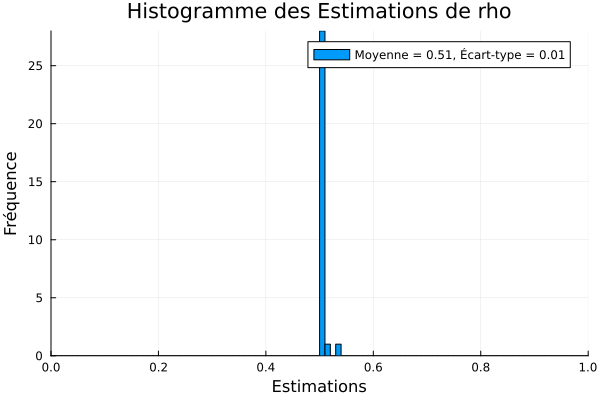

In [177]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_rho)
std_estimation = std(estimations_rho)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_rho, bins=0:0.01:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de rho", xlims=(0, 1),
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

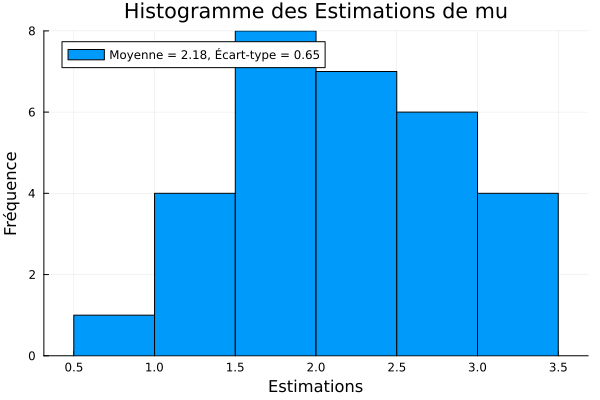

In [178]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_mu)
std_estimation = std(estimations_mu)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_mu, bins = 10, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de mu",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

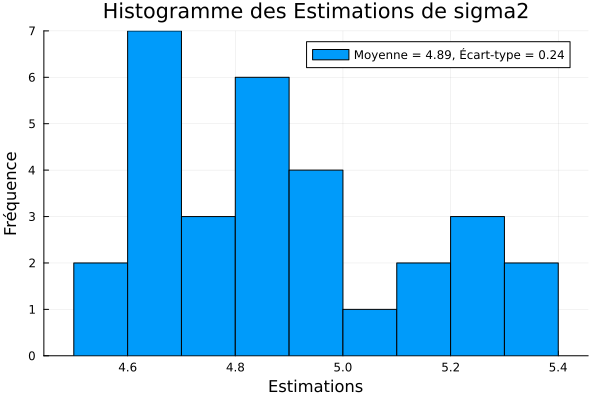

In [179]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_sigma2)
std_estimation = std(estimations_sigma2)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_sigma2, bins = 10, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de sigma2",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

In [180]:
mu = 2.0
sigma2 = 5.0
timestep = 2.
steps = 15
rho = 0.5
maintenance_times = [ 2. * i for i in 3:3:12]

estimations_rho = []
estimations_mu = []
estimations_sigma2 = []

psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(psARD1)
observations, times = observations_sampling(psARD1, 1)

for i in 1:50000
    # Créer une instance de WienerProcess
    psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(psARD1)
    observations, times = observations_sampling(psARD1, 1)
    delta_t = delta2(times)

    r = estimateur_rho_chapeau(psARD1.k, observations, delta_t)
    push!(estimations_rho, r)
    push!(estimations_mu, mu_chapeau(r, psARD1.k, observations, delta_t))
    push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, observations, delta_t))

end

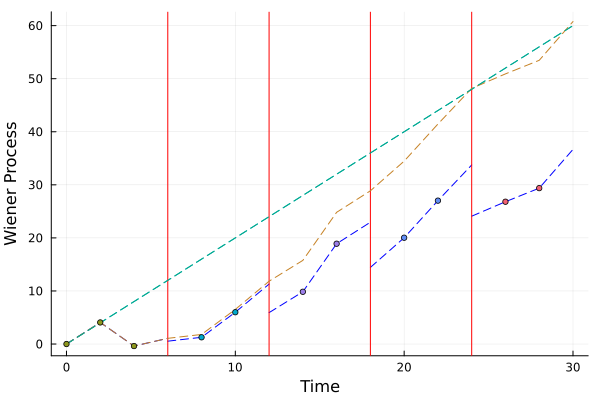

In [181]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(psARD1)
plot!(psARD1.underlying_process)
observations, times = observations_sampling(psARD1, 1)
for i in 1:psARD1.k+1
    scatter!(times[i], observations[i], markersize = 3)
end
plot!() 

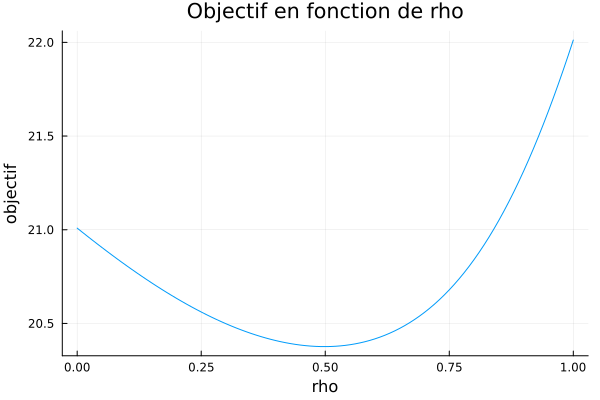

In [182]:
# Créer un vecteur de valeurs de rho entre 0 et 1
rhos = collect(0.0:0.01:1.)

# Calculer les valeurs de la fonction de vraisemblance pour chaque rho
vraisemblances = [objectif(rho, 2, observations, delta2(times), N) for rho in rhos]

# Tracer la fonction de vraisemblance
plot(rhos, vraisemblances, xlabel="rho", ylabel="objectif", title="Objectif en fonction de rho", legend = false)

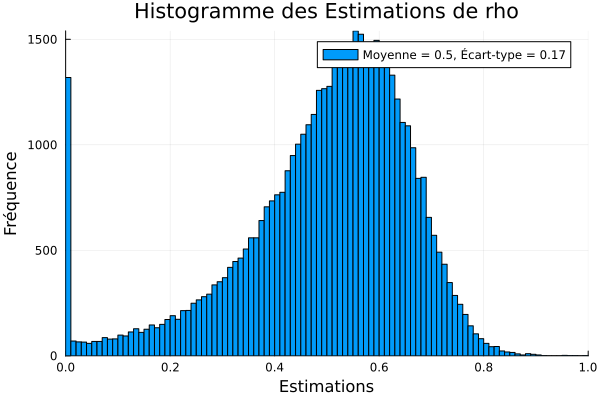

In [183]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_rho)
std_estimation = std(estimations_rho)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_rho, bins=0:0.01:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de rho", xlims=(0, 1),
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

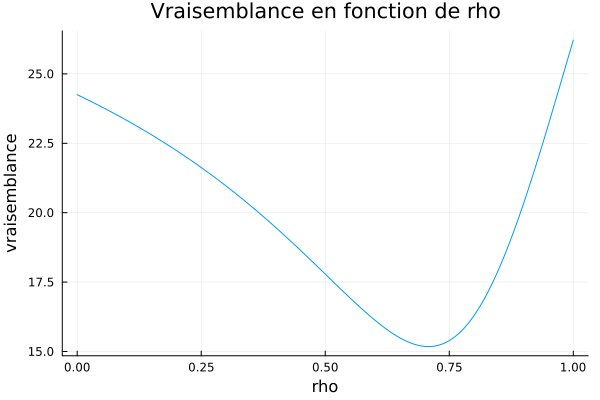

In [184]:
# Créer un vecteur de valeurs de rho entre 0 et 1
rhos = collect(0.0:0.01:1.)

# Calculer les valeurs de la fonction de vraisemblance pour chaque rho
vraisemblances = [objectif(rho, psARD1.k, psARD1.values, delta2(psARD1.new_times), N) for rho in rhos]

# Tracer la fonction de vraisemblance
plot(rhos, vraisemblances, xlabel="rho", ylabel="vraisemblance", title="Vraisemblance en fonction de rho", legend = false)

### Tester les estimateurs sur un sous-ensemble régulier de la trajectoire

In [186]:
mu = 2.0
sigma2 = 5.0
timestep = .01
steps = 1000
rho = 0.5
maintenance_times = [ 1. * i for i in 3:3:6]
estimations_rho = []
estimations_mu = []
estimations_sigma2 = []

psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(psARD1)
observations, times = observations_sampling(psARD1,70)

for i in 1:5000
    # Créer une instance de WienerProcess
    psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(psARD1)
    observations, times = observations_sampling(psARD1,70)
    delta_t2 = delta2(times)

    r = estimateur_rho_chapeau(psARD1.k, observations, delta_t2)
    push!(estimations_rho, r)
    push!(estimations_mu, mu_chapeau(r, psARD1.k, observations, delta_t2))
    push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, observations, delta_t2))
end

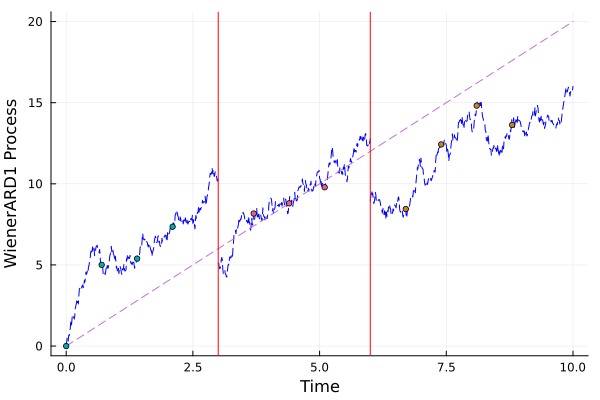

In [187]:
plot!(psARD1)
for i in 1:psARD1.k + 1
    scatter!(times[i], observations[i], markersize = 3 )
end
plot!()

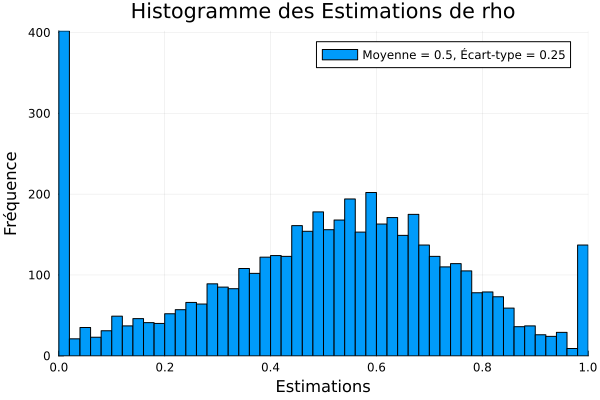

In [188]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_rho)
std_estimation = std(estimations_rho)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_rho, bins=0:0.02:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de rho", xlims=(0, 1),
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

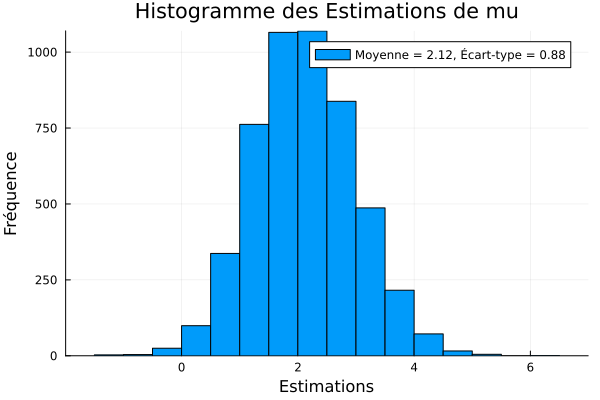

In [189]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_mu)
std_estimation = std(estimations_mu)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_mu, bins = 15, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de mu",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

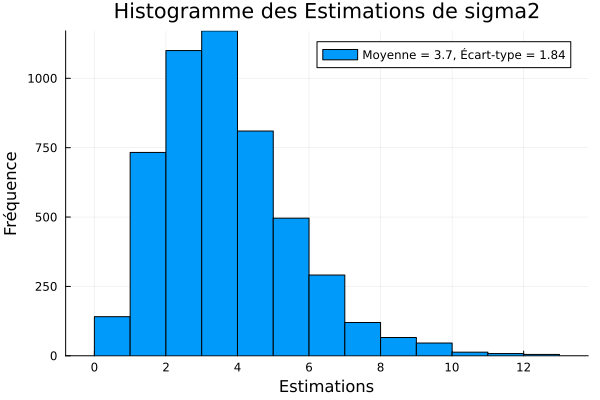

In [190]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_sigma2)
std_estimation = std(estimations_sigma2)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_sigma2, bins = 15, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de sigma2",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()